![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score
from sklearn.tree import DecisionTreeRegressor


In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


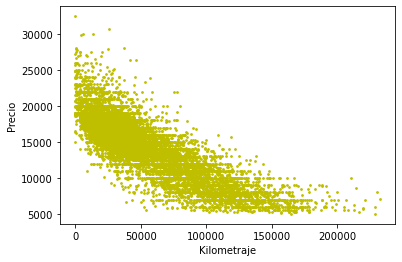

In [4]:
plt.scatter(data.Mileage,data.Price, s=3, color="y")
plt.xlabel('Kilometraje')
plt.ylabel('Precio')
plt.show()

En el gráfico se logra ver una relación lineal decreciente entre el kilometraje y el precio, a mayor kilometraje menor precio.

In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
X = data.drop(['Price'], axis=1)
y = data['Price']

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
import numpy as np
import pandas as pd
class Nodo():
    def __init__(self, indice_var=None, limite=None, izq=None, der=None, var_red=None, valor=None):
        
        # Para los nodos de decision
        self.indice_var = indice_var
        self.limite = limite
        self.izq = izq
        self.der = der
        self.var_red = var_red
        
        # Para el nodo hoja
        self.valor = valor

class ArbolDecisionReg():
    def __init__(self, min_samples_split=2, max_depth=2):
        
        # Inicializar la raiz del arbol
        self.raiz = None
        
        # Condiciones de parada
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def construir_arbol(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # Particionar hasta que se cumplan las condiciones de parada
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # Encontrar la mejor particion
            best_split = self.obtener_mejor_particion(dataset, num_samples, num_features)
            # Comprobar si la ganancia de información es positiva
            if best_split["var_red"]>0:
                izq_subtree = self.construir_arbol(best_split["dataset_izq"], curr_depth+1)
                der_subtree = self.construir_arbol(best_split["dataset_der"], curr_depth+1)
                # Retorna el nodo de decision
                return Nodo(best_split["indice_var"], best_split["limite"], 
                            izq_subtree, der_subtree, best_split["var_red"])
        
        # Calcular el nodo hoja
        leaf_valor = self.calcular_valor_hoja(Y)
        # Nodo hoja de retorno
        return Nodo(valor=leaf_valor)
    
    def obtener_mejor_particion(self, dataset, num_samples, num_features):
        
        # Diccionario para almacenar la mejor division
        best_split = {}
        max_var_red = -float("inf")
        # Recorrer todas las variables
        for indice_var in range(num_features):
            feature_valors = dataset[:, indice_var]
            possible_limites = np.unique(feature_valors)
            # recorrer todos los valores de características presentes en los datos
            for limite in possible_limites:
                # obtener división actual
                dataset_izq, dataset_der = self.split(dataset, indice_var, limite)
                # comprobar que no hayan nulos en los nodos hijos
                if len(dataset_izq)>0 and len(dataset_der)>0:
                    y, izq_y, der_y = dataset[:, -1], dataset_izq[:, -1], dataset_der[:, -1]
                    # Calcular la ganancia de información
                    curr_var_red = self.reduccion_varianza(y, izq_y, der_y)
                    # actualice la mejor división si es necesario
                    if curr_var_red>max_var_red:
                        best_split["indice_var"] = indice_var
                        best_split["limite"] = limite
                        best_split["dataset_izq"] = dataset_izq
                        best_split["dataset_der"] = dataset_der
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # retorna la mejor partición
        return best_split
    
    def split(self, dataset, indice_var, limite):
        
        dataset_izq = np.array([row for row in dataset if row[indice_var]<=limite])
        dataset_der = np.array([row for row in dataset if row[indice_var]>limite])
        return dataset_izq, dataset_der
    
    def reduccion_varianza(self, parent, l_child, r_child):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calcular_valor_hoja(self, Y):
        
        val = np.mean(Y)
        return val
                
    def imprimir_arbol(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.raiz

        if tree.valor is not None:
            print(tree.valor)

        else:
            print("X_"+str(tree.indice_var), "<=", tree.limite, "?", tree.var_red)
            print("%sizq:" % (indent), end="")
            self.imprimir_arbol(tree.izq, indent + indent)
            print("%sder:" % (indent), end="")
            self.imprimir_arbol(tree.der, indent + indent)
    
    def entrenar(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.raiz = self.construir_arbol(dataset)
        
    def hacer_prediccion(self, x, tree):
        
        if tree.valor!=None: return tree.valor
        feature_val = x[tree.indice_var]
        if feature_val<=tree.limite:
            return self.hacer_prediccion(x, tree.izq)
        else:
            return self.hacer_prediccion(x, tree.der)
    
    def predecir(self, X):
        
        preditions = [self.hacer_prediccion(x, self.raiz) for x in X]
        return preditions

In [10]:
arbol = ArbolDecisionReg(min_samples_split=4, max_depth=4)
arbol.entrenar(X_train.values,y_train.values.reshape(-1,1))
arbol.imprimir_arbol()

X_0 <= 2012 ? 8790046.173046965
 izq:X_0 <= 2011 ? 2959465.8517095316
  izq:X_1 <= 99121 ? 1170116.721087044
    izq:X_0 <= 2007 ? 893698.6400833833
        izq:X_1 <= 49149 ? 329938.2927407725
                izq:9976.375
                der:8193.566666666668
        der:X_1 <= 64249 ? 512626.0269236788
                izq:11691.425196850394
                der:10056.381868131868
    der:X_0 <= 2009 ? 552919.3704753756
        izq:X_1 <= 140695 ? 208501.18736617523
                izq:7536.089947089947
                der:6544.451807228916
        der:X_1 <= 123916 ? 671581.2715428071
                izq:9490.535714285714
                der:7780.9358974358975
  der:X_1 <= 82133 ? 1363726.4906349215
    izq:X_1 <= 47312 ? 504080.0386649659
        izq:X_2 <= 0 ? 363424.6206432851
                izq:14421.585365853658
                der:16228.083333333334
        der:X_2 <= 0 ? 162844.72614528518
                izq:12939.13679245283
                der:14252.84
    der:X_1 <= 112714

In [11]:
y_pred = arbol.predecir(X_test.values) 

# Métricas
rmse = np.sqrt(np.square(y_test - y_pred).mean())
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE: ", rmse) 
print("MAE: ", mae)
print('R2: ',r2)

RMSE:  1719.4119949906406
MAE:  1291.16524580749
R2:  0.806724017309669


In [18]:
mae / y_test.mean()

0.08843618033056733

Se crea un arbol de decision manual el cual se evalua con la muestra de test con las metricas RMSE, MAE y R2.

Tenemos un R2 de **0.806**, esto nos indica que el modelo tuvo un buen desempeño en ternimos generales.

por otra parte el MAE fue de **1291.16** que al compararlo con la media de precios en la muestra de test, corresponde a un **8.84%**. este sería el porcentaje de error medio en las predicciones del modelo.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [13]:
# Celda 2
# Siguiendo el ejemplo del taller de ensamblajes de la semana 1
# Fijamos una semilla para el muestreo aleatorio
np.random.seed(10)

# Se crea un arreglo de 1 a 11 para 
nums = np.arange(1, 11)

# Creación de 10 muestras de bootstrap 
np.random.seed(10)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples
# Visualización muestra boostrap #1 para entrenamiento
X_train.iloc[samples[0], :]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=10)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_i = X_train.iloc[sample, :]
    y_train_i = y_train.iloc[sample]
    treereg.fit(X_train_i, y_train_i)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred.mean(axis=1))
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred.mean(axis=1))
mape = np.mean(np.abs((y_test - y_pred.mean(axis=1)) / y_test)) * 100
adj_r2 = r2_score(y_test, y_pred.mean(axis=1))

#Imprimir las métricas de evaluación
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print("Adjusted R2: ", adj_r2)

RMSE:  1985.451643007342
MAE:  1488.5990184757507
MAPE:  10.751453544300185
Adjusted R2:  0.7422868295452214


Al implementar el método de ensamble de Bagging, logramos a través de muestreos de nuestros datos estimar múltiples regresiones con árboles diferentes, posteriormente hacemos predicción a partir del promedio de las predicciones de árboles individuales. El desempeño de este método es teóricamente mejor al árbol de decisión manual comparado bajo la métrica del RMSE, pues al promediar varios árboles reduce la varianza entre estimaciones con un menor compromiso en términos precisión (bajo error medio). Sin embargo, obtuvimos un R2 ajustado menor y un RMSE mayor que el del árbol individual.  

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [20]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador

from sklearn.ensemble import BaggingRegressor

import math

n_features=X_train.shape[1]

bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1, max_features= math.log(n_features) )
# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
adj_r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print("Adjusted R2: ", adj_r2)

ValueError: max_features must be in (0, n_features]

La implementación de Baggin por librería, aplica el mismo principio que el desarrollado manualmente pero obtuvo un mejor resultado si tenemos en cuenta la métrica del R2 adjustado ( donde un mayor valor es mejor, obtuvimos 0.74 Bagging libreria > 0.64 Bagging manual), así como en la métrica del RMSE (donde un menor valor es mejor,  1988 Bagging libreria< 2334 Bagging manual).

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [18]:
# Celda 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Implementación modelo Random Forest para Regresión
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# metricas de desempeño 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
adj_r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Adjusted R2: ", adj_r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)


# Distribución de r2 
print('Distribución de r2:')
pd.Series(cross_val_score(rf_model, X, y, cv=10,scoring='r2')).describe()

Adjusted R2:  0.7966969962684598
MSE:  3109752.3841816843
RMSE:  1763.4490024329268
MAE:  1314.094721987797
MAPE:  9.552626762216407
Distribución de r2:


count    10.000000
mean      0.801293
std       0.010876
min       0.783475
25%       0.796219
50%       0.802129
75%       0.805779
max       0.817276
dtype: float64

Aplicando el modelo de Random Forest para predecir el precio de un automóvil se tiene un MSE de 3.078.505 y un R2 de 0.79, esto sin realizar calibración de parámetros. Adicionalmente se realiza con un modulo de "ensemble" utilizando validación cruzada y después de aplicar con k-fold cross validation un k de 10 se obtiene la distribución del r2 identificando así que el promedio del r2 está en 0.80 con un mínimo del 0.78 y un máximo de 0.81 siendo un resultado no tan disperso.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [19]:
# Calibración de n_estimators
print('**************************Calibración de n_estimators************************')
estimator_range = range(10, 310, 10)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for estimator in estimator_range:
    rf_model = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Visualización de las métricas
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.ravel()

axes[0].plot(estimator_range, R2_scores)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('R2 Score')

axes[1].plot(estimator_range, MSE_scores)
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('MSE Score')

axes[2].plot(estimator_range, RMSE_scores)
axes[2].set_xlabel('n_estimators')
axes[2].set_ylabel('RMSE Score')

axes[3].plot(estimator_range, MAE_scores)
axes[3].set_xlabel('n_estimators')
axes[3].set_ylabel('MAE Score')

axes[4].plot(estimator_range, MAPE_scores)
axes[4].set_xlabel('n_estimators')
axes[4].set_ylabel('MAPE Score')

plt.tight_layout()
plt.show()

**************************Calibración de n_estimators************************


KeyboardInterrupt: 

In [ ]:
print('**************************Calibración de max_features************************')
feature_range = range(1, len(X.columns)+1)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for feature in feature_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Graficar resultados
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].plot(feature_range, R2_scores)
axes[0,0].set_xlabel('max_features')
axes[0,0].set_ylabel('R2 Score')

axes[0,1].plot(feature_range, MSE_scores)
axes[0,1].set_xlabel('max_features')
axes[0,1].set_ylabel('MSE Score')

axes[1,0].plot(feature_range, RMSE_scores)
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('RMSE Score')

axes[1,1].plot(feature_range, MAE_scores)
axes[1,1].set_xlabel('max_features')
axes[1,1].set_ylabel('MAE Score')

plt.show()

**************************Calibración de max_depth************************


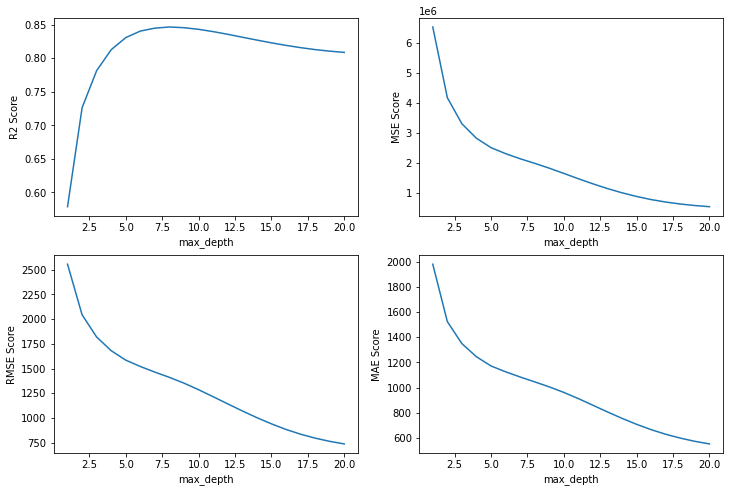

In [14]:
print('**************************Calibración de max_depth************************')
depth_range = range(1, 21)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for depth in depth_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Graficar resultados
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].plot(depth_range, R2_scores)
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('R2 Score')

axes[0,1].plot(depth_range, MSE_scores)
axes[0,1].set_xlabel('max_depth')
axes[0,1].set_ylabel('MSE Score')

axes[1,0].plot(depth_range, RMSE_scores)
axes[1,0].set_xlabel('max_depth')
axes[1,0].set_ylabel('RMSE Score')

axes[1,1].plot(depth_range, MAE_scores)
axes[1,1].set_xlabel('max_depth')
axes[1,1].set_ylabel('MAE Score')

plt.show()

Se procede a validar los parámetros más optimos para aplicar al modelo, iniciando con el número de arboles (n_estimators) que van a ser usados se selecciona un rango entre 10 y 310 para probar el cambio en los resultados del r2 a medida que va iterando sobre esta variable y por cada arbol se está haciendo una validación cruzada de 5, para este caso se evidencia que se alcanza el máximo r2 con aproximadamente 150 árboles de igual forma se evidencia para las métricas del MSE, RMSE, MAPE Y EL MAE.

Posteriormente se busca identificar el número máximo de variables (max_features) con las cuáles nuestro modelo tendría un mejor desempeño, para lo cuál se itera sobre el número total de variables que tenemos en el dataset, sin embargo en este caso al tener pocas variables nos arroja que el r2 llega a su punto máximo cuando toma todas las variables entendiendo que los árboles serían iguales y ya no tendrían tanta aleatoriedad, de igual forma se da para las demás métricas como el MSE, RMSE , MAPE Y MAE. Esto podría ser de mayor impacto si tuvieramos un mayor número de variables en nuestro dataset.

Por último se realiza iteración sobre la profundidad de los árboles (max_depth) en donde se busca limitar la profundidad que puede alcanzar cada arbol de decisión individual, para este caso se evidencia que alcanza un máximo r2 con aproximadamente 8 y para las demás métricas entre más alta sea la profundidad se alcanza un mjeor resultado, sin embargo esto puede representar cierta complejidad computacional para datasets más grandes.

In [ ]:
#Implementación del modelo Random Forest para Regresión con los mejores parámetros

rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('***Métricas para Test:')
print('R2: ', r2)
print('MSE: ', mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print('                          ')

print('***Métricas para Train:')
rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
print('R2: ', r2)
print('MSE: ', mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)

En este paso se entrena el modelo Random Forest utilizando los mejores parametros identificados en el paso anterior con lo cuál se evidencia un mejor desempeño del modelo con calibración de n_estimators=150, max_depth=8,max_features=9 en donde se obtuvo un r2 0.84 evaluando test y 0.87 evaluando con train a diferencia del modelo aplicado en el punto 4 con el cuál se obtuvo un r2 0.79. Adicionalmente se validan las metricas de desempñeo sobre train con el fin de descartar que el modelo tenga overfitting encontrando un buen resultado también para este caso.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [17]:
# Celda 6
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
model = xgb.XGBRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
yPred = model.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, yPred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, yPred)
mape = np.mean(np.abs((y_test - yPred) / y_test)) * 100
adj_r2 = r2_score(y_test, yPred)

# Imprimir las métricas de evaluación
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print("R2 Ajustado: ", adj_r2)



RMSE:  1808.2736525682112
MAE:  1362.6027492320566
MAPE:  9.864948016905288
R2 Ajustado:  0.7862302276712319


Aplicando el modelo Xboost para predecir el precio de un automóvil se tiene un RMSE de 1621 y un R2 de 0.82, un MAPE de 8.6%,sin realizar calibración de parámetros.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

*------Learning rate---------*
------------- Evaluación con test----------------


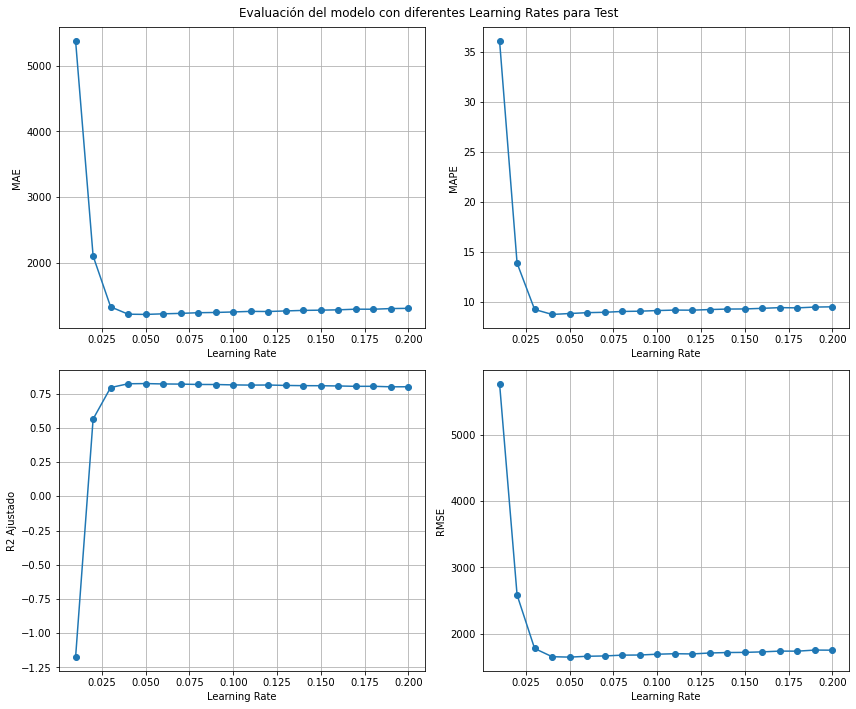

El mejor valor de learning rate para datos de prueba es: 0.05
------------- Evaluación con train----------------


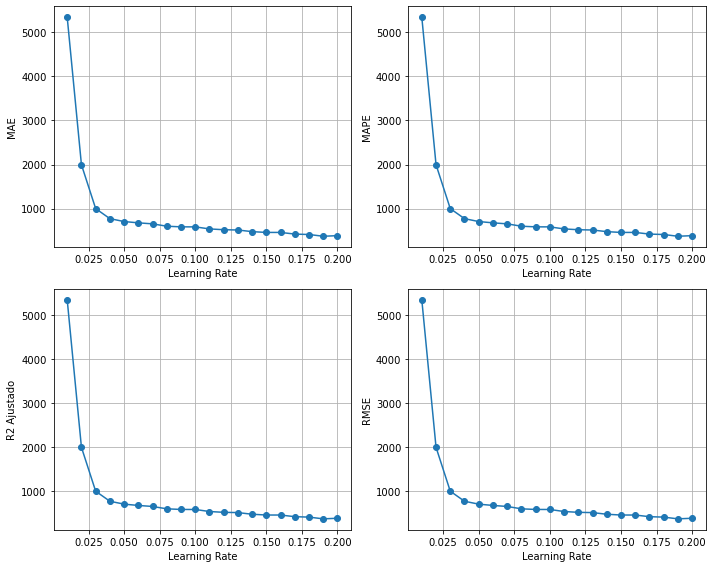

El mejor valor de learning rate para datos de prueba es: 0.19


In [18]:
# Celda 7
## Learning rate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de learning rate a calibrar
print('*------Learning rate---------*')
learning_rates = np.arange(0.01, 0.21, 0.01)

# Crear listas para guardar los resultados de las métricas y el learning rate
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
learning_rate_results = []

# Iterar sobre los diferentes valores de learning rate
for lr in learning_rates:
    # Crear el modelo de XGBoost con el valor de learning rate actual
    model = XGBRegressor(learning_rate=lr)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de learning rate
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    learning_rate_results.append(lr)

# Obtener el índice del mejor valor de learning rate basado en el MAE en datos de prueba
best_lr_idx_test = np.argmin(mae_results_test)
best_lr_test = learning_rates[best_lr_idx_test]

# Obtener el índice del mejor valor de learning rate basado en el MAE en datos de entrenamiento
best_lr_idx_train = np.argmin(mae_results_train)
best_lr_train = learning_rates[best_lr_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes Learning Rates para Test')

# Gráfico para el MAE
axes[0, 0].plot(learning_rate_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(learning_rate_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(learning_rate_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(learning_rate_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de learning rate para datos de prueba y de entrenamiento
print(f"El mejor valor de learning rate para datos de prueba es: {best_lr_test}")

print('------------- Evaluación con train----------------')


# Gráfico para el MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(learning_rate_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(learning_rate_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(learning_rate_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(learning_rate_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de learning rate para datos de prueba es: {best_lr_train}")


*------gamma---------*
------------- Evaluación con test----------------


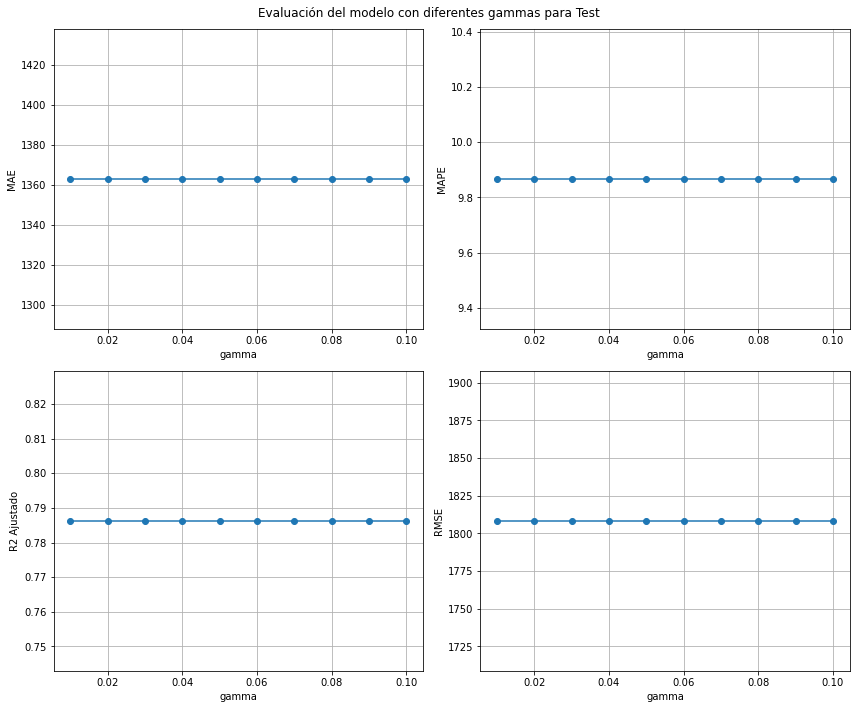

El mejor valor de gamma para datos de prueba es: 0.01
------------- Evaluación con train----------------


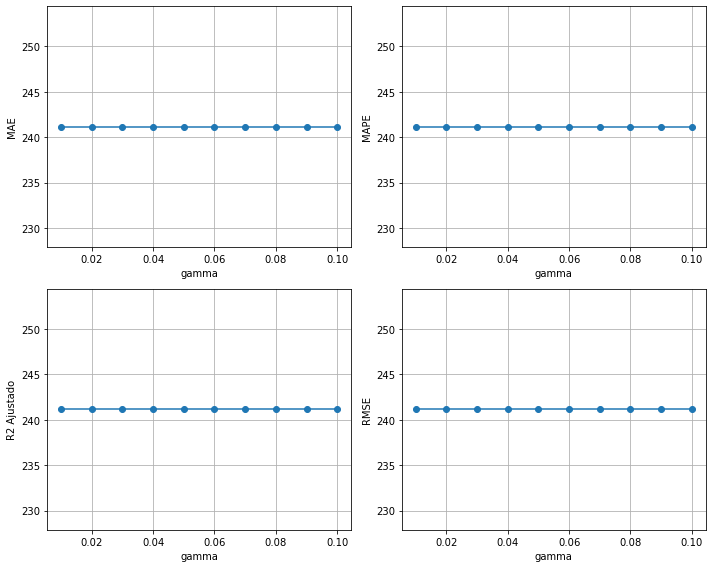

El mejor valor de gamma para datos de prueba es: 0.01


In [19]:
## gamma
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de gamma a calibrar
print('*------gamma---------*')
gammas = np.arange(0.01, 0.11, 0.01)

# Crear listas para guardar los resultados de las métricas y el gamma
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
gamma_results = []

# Iterar sobre los diferentes valores de gamma
for gam in gammas:
    # Crear el modelo de XGBoost con el valor de gamma actual
    model = XGBRegressor(gamma=gam)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de gamma
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    gamma_results.append(gam)

# Obtener el índice del mejor valor de gamma basado en el MAE en datos de prueba
best_gam_idx_test = np.argmin(mae_results_test)
best_gam_test = gammas[best_gam_idx_test]

# Obtener el índice del mejor valor de gamma basado en el MAE en datos de entrenamiento
best_gam_idx_train = np.argmin(mae_results_train)
best_gam_train = gammas[best_gam_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes gammas para Test')

# Gráfico para el MAE
axes[0, 0].plot(gamma_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('gamma')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(gamma_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('gamma')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(gamma_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(gamma_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('gamma')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de gamma para datos de prueba y de entrenamiento
print(f"El mejor valor de gamma para datos de prueba es: {best_gam_test}")

print('------------- Evaluación con train----------------')


#MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(gamma_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('gamma')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(gamma_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('gamma')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(gamma_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

#RMSE
axes[1, 1].plot(gamma_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('gamma')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de gamma para datos de prueba es: {best_gam_train}")


*------colsamp---------*
------------- Evaluación con test----------------


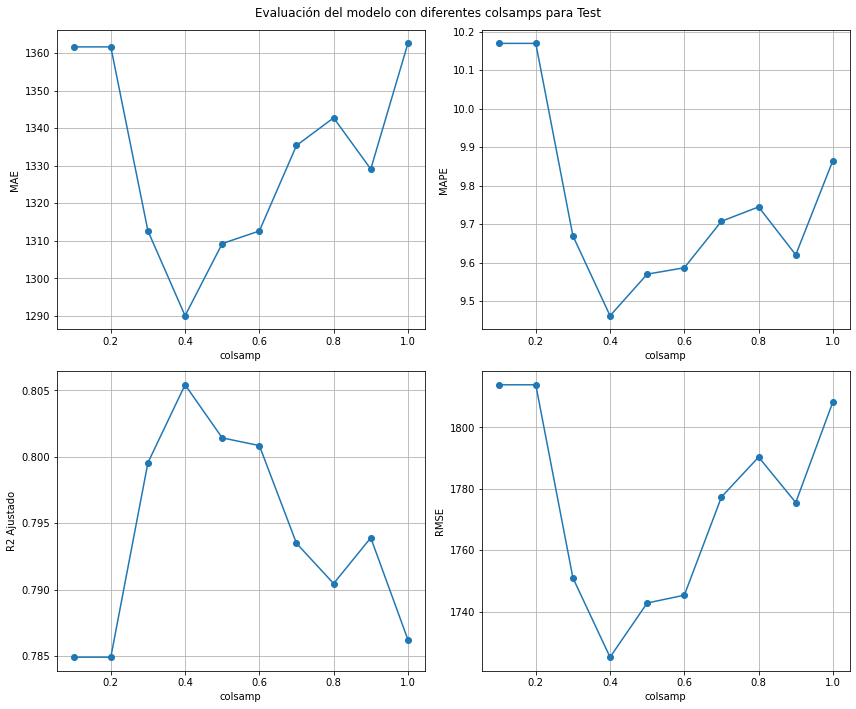

El mejor valor de colsamp para datos de prueba es: 0.4
------------- Evaluación con train----------------


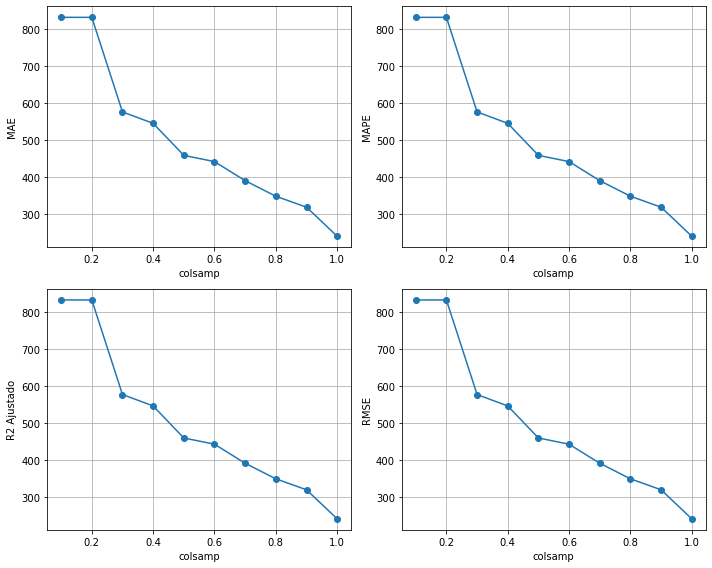

El mejor valor de colsamp para datos de prueba es: 1.0


In [20]:


## colsample_bytree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de colsamp a calibrar
print('*------colsamp---------*')
colsample_bytrees = np.arange(0.1, 1.1, 0.1)

# Crear listas para guardar los resultados de las métricas y el colsamp
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
colsample_bytree_results = []

# Iterar sobre los diferentes valores de colsamp
for col in colsample_bytrees:
    # Crear el modelo de XGBoost con el valor de colsamp actual
    model = XGBRegressor(colsample_bytree=col)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de colsamp
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    colsample_bytree_results.append(col)

# Obtener el índice del mejor valor de colsamp basado en el MAE en datos de prueba
best_col_idx_test = np.argmin(mae_results_test)
best_col_test = colsample_bytrees[best_col_idx_test]

# Obtener el índice del mejor valor de colsamp basado en el MAE en datos de entrenamiento
best_col_idx_train = np.argmin(mae_results_train)
best_col_train = colsample_bytrees[best_col_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes colsamps para Test')

#MAE
axes[0, 0].plot(colsample_bytree_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('colsamp')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(colsample_bytree_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('colsamp')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(colsample_bytree_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('colsamp')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# RMSE
axes[1, 1].plot(colsample_bytree_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('colsamp')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de colsamp para datos de prueba y de entrenamiento
print(f"El mejor valor de colsamp para datos de prueba es: {best_col_test}")

print('------------- Evaluación con train----------------')


#MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('colsamp')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('colsamp')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('colsamp')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

#RMSE
axes[1, 1].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('colsamp')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de colsamp para datos de prueba es: {best_col_train}")


Luego de realizar pruebas con varios valores para los hiperparametros, eligiendo el MAE como métrica para elegir el mejor, se obtuvo lo siguiente:
1. Learning rate:
Se realizó una evaluación del modelo para valores entre 0.01 y 0.2, encontrando así el valor de 0.05 en donde se puede observar que se encuentra el menor valor de MAE, MAPE y RMSE donde tienen una reducción significativa, igualmente con R2 ajustado con su mayor valor,
un learning rate bajo evita el posible sobreajuste presentado en el modelo.
2. gamma:
Se realizó una evaluación del modelo para valores entre 0.01 y 0.1,se puede observar que los valores a utilizar no generan mayor variación en los indicadores de desempeño del modelo tanto para test como para train, este valor nos garantiza un modelo más complejo al regular la función de pérdida.
3. Colsample_bytree:
Se realizó una evaluación del modelo para valores entre 0.1 y 1, encontrando así el valor de 0.4 en donde se puede observar que se encuentra el menor valor de MAE, MAPE y RMSE, igualmente con R2 ajustado con su mayor valor, este parámetro es utilizado para seleccionar el porcentaje de variables para incluir en el modelo.

In [21]:
#Evaluar el modelo con los mejores parámetros.
model = XGBRegressor(colsample_bytree=0.4,learning_rate=0.05,gamma=0.01)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
yPred = model.predict(X_test)
# Calcular las métricas de evaluación en datos de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
adj_r2_train = r2_score(y_train, y_train_pred)

# Calcular las métricas de evaluación en datos de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
adj_r2_test = r2_score(y_test, y_test_pred)

# Imprimir las métricas de evaluación
print("Métricas en datos de entrenamiento:")
print("RMSE: ", rmse_train)
print("MAE: ", mae_train)
print("MAPE: ", mape_train)
print("R2 Ajustado: ", adj_r2_train)
print('-----------------------------')
print("Métricas en datos de prueba:")
print("RMSE: ", rmse_test)
print("MAE: ", mae_test)
print("MAPE: ", mape_test)
print("R2 Ajustado: ", adj_r2_test)

Métricas en datos de entrenamiento:
RMSE:  1185.5230246699523
MAE:  882.0427487421775
MAPE:  6.18705620912924
R2 Ajustado:  0.9102298130890994
-----------------------------
Métricas en datos de prueba:
RMSE:  1629.16697442094
MAE:  1214.2935602130847
MAPE:  8.87887544271212
R2 Ajustado:  0.8264801429484699


Por último, se evalua de nuevo el modelo con los parámetros obtenidos observando que aumenta el r2 ajustado en 0.02 con un valor final de r2 ajustado de 0.84, además obteniendo menores valores de RMSE,MAE y MAPE,esto nos dice que para predecir el precio de un automóvil, la predicción puede variar en 1142 dolares y representa el 8% del valor de la predicción, para validar el sobreajuste se evalua el modelo con los datos en entrenamiento y prueba, obteniendo valores muy similares, comprobando así que el modelo no sufre de sobreajuste.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

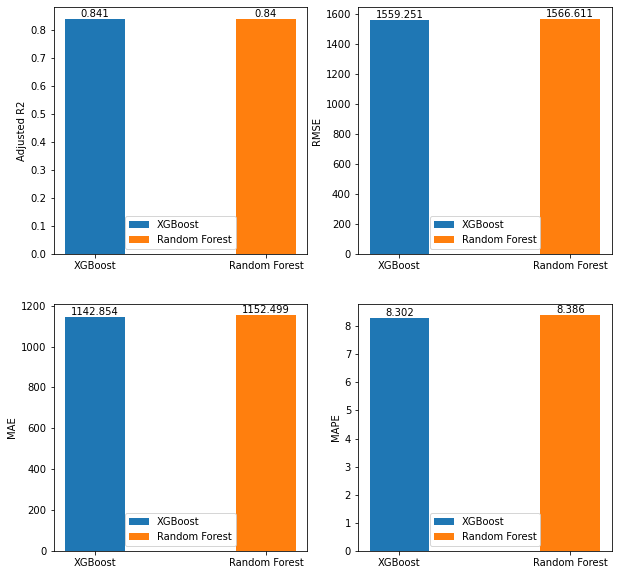

In [21]:
# Celda 8

# Celda 8
# Datos de XGBoost
xgb_adjusted_r2 = 0.8410538296889145
xgb_rmse = 1559.2510360733622
xgb_mae = 1142.8535779287854
xgb_mape = 8.302381170782883

# Datos de Random Forest
rf_adjusted_r2 = 0.8395497656934414
rf_rmse = 1566.6110479773974
rf_mae = 1152.4992213219855
rf_mape = 8.386380167364162

# Etiquetas de las métricas
labels = ['Adjusted R2', 'RMSE', 'MAE', 'MAPE']

# Configura el gráfico de barras para cada métrica
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, metric in enumerate(labels):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Valores de XGBoost y Random Forest
    xgb_value = [eval(f'xgb_{metric.lower().replace(" ", "_")}')]

    rf_value = [eval(f'rf_{metric.lower().replace(" ", "_")}')]

    # Configura el gráfico de barras
    x = [0, 1]
    width = 0.35
    ax.bar(x[0], xgb_value, width, label='XGBoost')
    ax.bar(x[1], rf_value, width, label='Random Forest')
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(['XGBoost', 'Random Forest'])

    # Agrega etiquetas a las barras
    ax.text(x[0], xgb_value[0], round(xgb_value[0], 3), ha='center', va='bottom')
    ax.text(x[1], rf_value[0], round(rf_value[0], 3), ha='center', va='bottom')

    ax.legend()

plt.show()

 Una vez realizada la calibración de los mejores parámetros para cada modelo, se evidencia que se obtiene un resultado muy similar, sin embargo con el modelo XGBoost se obtiene un mayor r2 ajustado 0.841 y un menor valor para las métricas de RMSE, MAE y MAPE. Decidimos elegir XGBoost ya que su procesamiento es más optimizado que el de un Random Forest y tiene más parámetros que inciden directamente en el desempeño predictivo del modelo lo que permite una mayor cantidad de parámetros a calibrar y mejorar así el desempeño del modelo. 